In [47]:
import xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
from src.mrms_qpe.fetch_mrms_qpe import MRMSQPEClient


_LAT_MIN = 34.751857
_LAT_MAX = 37.103662
_LON_MIN = -116.146925 + 360
_LON_MAX = -113.792819 + 360

ALL_EVENTS_DF = "./data/events/2021-01-01_2025-07-25_all_events.csv"
    

client = MRMSQPEClient()
date   = datetime(2023, 9, 2, 21, 46)
ar     = client.fetch_radar_only_qpe_1hr(date)

In [48]:
df = pd.read_csv(ALL_EVENTS_DF)

# filter out extreme values (i.e., <= 0.001 and >= 0.999 percentile)
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df["delta_qpe"] > df["delta_qpe"].quantile(0.001)) & (
    df["delta_qpe"] < df["delta_qpe"].quantile(0.999)
)
df = df.loc[mask]

# drop some unused columns
df = df.drop(["cum_gauge_qpe", "cum_mrms_qpe"], axis=1)

# convert start/end times to datetime objs
df["start_time"] = pd.to_datetime(df["start_time"])
df["event_time"] = pd.to_datetime(df["end_time"])

df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937,2021-01-24
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000,2021-01-24
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000,2021-01-24
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811,2021-01-24
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748,2021-01-24


In [50]:
def visualize_mrms_product(xarr: xarray.Dataset, product_name: str="") -> None:
    """
    Display a still frame of an `xarray.Dataset`
    """
    pass


# a grib2 file loaded into an xarray.Dataset
example_arr = ar

# [3500, 7000]; 1H-QPE (mm)
qpe_arr: xarray.DataArray = example_arr.unknown

# N, E
lat_mask    = (qpe_arr.latitude  < _LAT_MAX) & (qpe_arr.latitude  > _LAT_MIN)
lon_mask    = (qpe_arr.longitude < _LON_MAX) & (qpe_arr.longitude > _LON_MIN)
coords_mask = lat_mask & lon_mask

# LV valley region
qpe_arr_lv  = qpe_arr.values[coords_mask]

In [57]:
from typing import List


def retreive_gauge_info_for_dt(_df: pd.DataFrame, start_time: datetime) -> List[dict]:

    mask = (_df['start_time'].dt.year == start_time.year) & (df['start_time'].dt.month == start_time.month) \
        & (_df['start_time'].dt.day == start_time.day) & (_df['start_time'].dt.hour == start_time.hour) \
        & (_df['start_time'].dt.minute == start_time.minute)
    
    return _df[mask]


dt = datetime(2023, 9, 2, 21, 46)
gauge_info_df = retreive_gauge_info_for_dt(df, dt)
gauge_info_df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time
1393138,2023-09-02 21:46:00,2023-09-02 22:46:00,4094,36.098944,245.056417,0.04,0.145669,-0.105669,2023-09-02 22:46:00
1393139,2023-09-02 21:46:00,2023-09-02 22:46:00,4039,36.356417,244.863417,0.00,0.011811,-0.011811,2023-09-02 22:46:00
1393140,2023-09-02 21:46:00,2023-09-02 22:46:00,4144,36.336667,245.081667,0.00,0.649606,-0.649606,2023-09-02 22:46:00
1393141,2023-09-02 21:46:00,2023-09-02 22:46:00,4254,36.225306,244.746750,0.00,0.003937,-0.003937,2023-09-02 22:46:00
1393142,2023-09-02 21:46:00,2023-09-02 22:46:00,4209,36.206472,244.628511,0.00,0.019685,-0.019685,2023-09-02 22:46:00


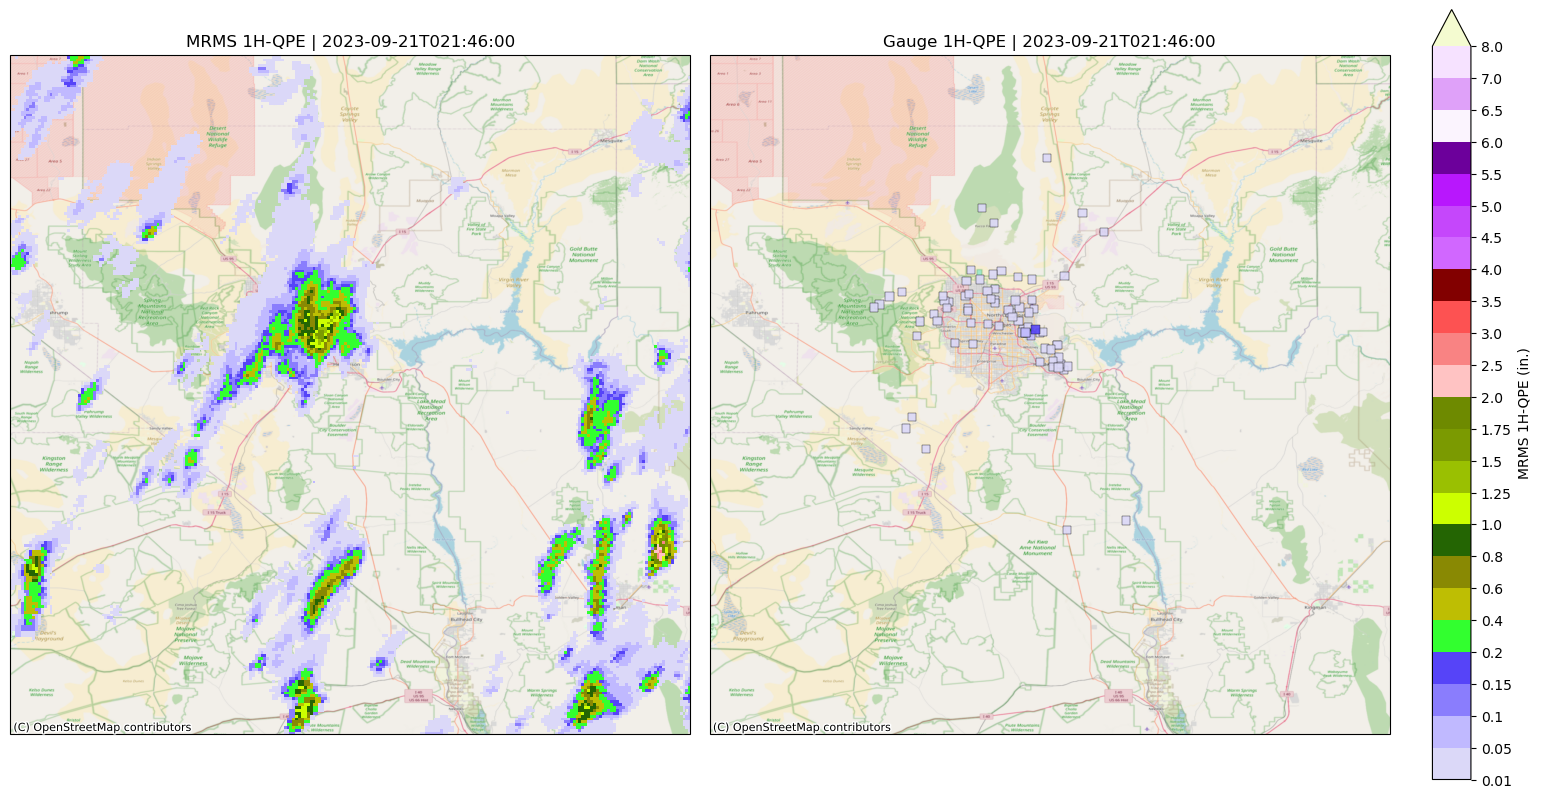

In [ ]:
import xarray as xr
import contextily as cx
import xyzservices.providers as xyz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from src.plot.magic import MRMS_1H_QPE_PALLETE, MRMS_1H_QPE_BOUNDARIES


# pallete from NSSL MRMS web viewer
colors = MRMS_1H_QPE_PALLETE
boundaries = MRMS_1H_QPE_BOUNDARIES

cmap = mcolors.ListedColormap(colors)
cmap.set_bad((0, 0, 0, 0))
norm = mcolors.BoundaryNorm(boundaries, cmap.N, extend='max')

# QPE (mm -> in)
ds = example_arr.unknown.sel(
    latitude=slice(_LAT_MAX,  _LAT_MIN),
    longitude=slice(_LON_MIN, _LON_MAX),
) / 25.4

ds_masked = ds.where(ds >= 0.01)

fig = plt.figure(figsize=(20, 10), dpi=600)
gs  = fig.add_gridspec(1, 2, width_ratios=[1, 1.25], wspace=0.025)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())

# same limits as the data slice
ax1.set_extent([_LON_MIN, _LON_MAX, _LAT_MIN, _LAT_MAX], crs=ccrs.PlateCarree())
ax2.set_extent([_LON_MIN, _LON_MAX, _LAT_MIN, _LAT_MAX], crs=ccrs.PlateCarree())

# add basemap; tell contextily our axis units are degrees
cx.add_basemap(ax1, crs="EPSG:4326", source=xyz.OpenStreetMap.Mapnik, zoom=10)
cx.add_basemap(ax2, crs="EPSG:4326", source=xyz.OpenStreetMap.Mapnik, zoom=10)

# plot subset
ds_masked.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    norm=norm,
    cmap=cmap,
    add_colorbar=False,
);

# ---- plot gauges ----
g_lons = []
g_lats = []
g_vals = []
g_ids  = []

for item in gauge_info_df.iterrows():

    g_lons.append(item[1]["lon"])
    g_lats.append(item[1]["lat"])
    g_vals.append(item[1]["delta_qpe"])
    g_ids.append(item[1]["station_id"])

sc = ax2.scatter(
    g_lons,
    g_lats,
    c=g_vals,
    cmap=cmap,
    norm=norm,
    edgecolors="black",
    linewidths=0.30,
    s=35,
    alpha=.90,
    marker='s',
    transform=ccrs.PlateCarree(),
    zorder=5,
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax2, orientation='vertical', pad=0.05)
cbar.set_label('MRMS 1H-QPE (in.)')
cbar.set_ticks(boundaries)
cbar.set_ticklabels([str(b) for b in boundaries])

ax1.set_title(f"MRMS 1H-QPE | 2023-09-21T021:46:00")
ax2.set_title(f"Gauge 1H-QPE | 2023-09-21T021:46:00")
plt.show()